In [84]:
import sys
import os
import json
import time
from dotenv import load_dotenv
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

### Set working directory

In [2]:
# Set working directory here
WD = '/Users/johnmichael/Documents/DATA512/data512-common-analysis/'

### Process USGS Wildfire data

The following code processes the wildfire data from the Uniged States Geological Survey. The code is adapted from 'code/wildfire_geo_proximity_example.ipynb', which uses the Python class defined in 'code/wildfire'. See the notebook and the Python class for full license information. The wildfire data set from USGS contains wildfires up to 2020.

In [3]:
# Constants for wildfire processing

# JSON Filename of wildfire dataset
# Source: https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81
EXTRACT_FILENAME = "input/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"

# Create full path using filename
SAMPLE_DATA_FILENAME = os.path.join(WD,EXTRACT_FILENAME)

# Store city location information in a dictionary
CITY_LOCATIONS = {'texarkana': {'city'   : 'Texarkana',
                                'latlon' : [33.437222, -94.0675]}}

# Set to infinity so that we process each wildfire in the dataset
# To process only a subset, change MAX_FEATURE_LAOD to a desired number
MAX_FEATURE_LOAD = float('Inf')

In [4]:
'''
This bit of code opens a new wildfire reader,
gets the header information and prints it to the screen
if desired.
'''
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)

# Print header_dict to see what the wildfire data looks like
header_dict = wfreader.header()
header_keys = list(header_dict.keys())


Attempting to open '/Users/johnmichael/Documents/DATA512/data512-common-analysis/input/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object


In [5]:
# This sample code will load the whole sample file, or a small amount of the complete dataset.
feature_list = list()
feature_count = 0

# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result
wfreader.rewind()

# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()

# Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")

# Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features
Variable 'feature_list' contains 135061 features


In [6]:
# Transform feature geometry data
# The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
# The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        if isinstance(coord, dict):
            lat, lon = to_epsg4326.transform(list(coord.values())[0][0][0],
                                             list(coord.values())[0][0][1])
        else:
            lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [7]:
# The function takes two parameters
# A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
# Ring_data - a list of decimal degree coordinates for the fire boundary
# The function returns a list containing the shortest distance to the perimeter and the point where that is
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

In [8]:
# Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATIONS["texarkana"]
distances_df = pd.DataFrame()

for i, wf_feature in enumerate(feature_list):
    if i % 10000 == 0:
        print(f'Number of features processed: {i}')

    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    if 'curveRings' in wf_feature['geometry'].keys():
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        ring_data = wf_feature['geometry']['rings'][0]

    # Compute using the shortest distance to any point on the perimeter
    distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'], ring_data)
    
    # Store the result in a Pandas dataframe
    df = pd.DataFrame({'year': [wf_year],
                       'name': [wf_name],
                       'size_acres': [wf_size],
                       'type': [wf_type],
                       'distance_to_txk': [distance[0]],
                       'sd_lat': [distance[1][0]],
                       'sd_lon': [distance[1][1]]})
    distances_df = pd.concat([distances_df, df])

Number of features processed: 0
Number of features processed: 10000
Number of features processed: 20000
Number of features processed: 30000
Number of features processed: 40000
Number of features processed: 50000
Number of features processed: 60000
Number of features processed: 70000
Number of features processed: 80000
Number of features processed: 90000
Number of features processed: 100000
Number of features processed: 110000
Number of features processed: 120000
Number of features processed: 130000


In [9]:
# Export the dataframe to a csv which we can read in later
distances_df.to_csv(os.path.join(WD, 'intermediate/distances.csv'), index=False)

### Pull Air Quality Index (AQI) from AQS

The following code pulls air quality data from the US Environmental Protection Agency's Air Quality Service (AQS) API. The code is adapted from 'code/epa_air_quality_history_example.ipynb' See the notebook for full license information.

In [10]:
# CONSTANTS for AQS API

# This is the root of all AQS API URLs
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

# These are 'actions' we can ask the API to take or requests that we can make of the API
# Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'

# List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

# Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

# Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

# It is always nice to be respectful of a free data resource.
# We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

'''
This is a template that covers most of the parameters for the actions we might take,
from the set of actions above. In the examples below, most of the time parameters 
can either be supplied as individual values to a function - or they can be set in 
a copy of the template and passed in with the template. 
'''
AQS_REQUEST_TEMPLATE = {
    "email": "",     
    "key": "",      
    "state": "", # the two digit state FIPS # as a string
    "county": "", # the three digit county FIPS # as a string
    "begin_date": "", # the start of a time window in YYYYMMDD format
    "end_date": "", # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat": 0.0,
    "maxlat": 0.0,
    "minlon": 0.0,
    "maxlon": 0.0,
    "param": "", # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass": "" # parameter class is only used by the List calls
}
USERNAME = 'jmic94@uw.edu'


# Load the API key from the .env file
# make sure the .env file has the API key
# Refer to the README for more information
load_dotenv()
APIKEY = os.getenv('AQS_API')

# We want to pull from 1963 to 2023
STARTYEAR = 1963
ENDYEAR = 2023

In [11]:
'''
Once we have a list of the classes or groups of possible sensors, 
we can find the sensor IDs that make up that class (group).
The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS".
We'll use that to make another list request.
'''
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [12]:
'''
Given the set of sensor codes, now we can create a parameter list 
or 'param' value as defined by the AQS API spec. It turns out that we 
want all of these measures for AQI, but we need to have two different 
param constants to get all seven of the code types. We can only have a 
max of 5 sensors/values request per param.
'''

# Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"

# Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

In [13]:
# We'll use this city location below.
CITY_LOCATIONS = {
    'texarkana': {'city': 'Texarkana',
                  'county': 'Bowie',
                  'state': 'Texas',
                  'fips': '48037',
                  'latlon': [33.437222, -94.0675]}
}

In [14]:
'''
These are rough estimates for creating bounding boxes based on a city location.
You can find these rough estimates on the USGS website:
https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps.
'''
LAT_25MILES = 25.0 * (1.0/69.0) # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6) # This is about 25 miles of longitude in decimal degrees


'''
Compute rough estimates for a bounding box around a given place.
The bounding box is scaled in 50 mile increments.
That is the bounding box will have sides that are rough multiples of 50 miles, 
with the center of the box around the indicated place.
The scale parameter determines the scale (size) of the bounding box.
'''
def bounding_latlon(place=None,scale=1.0):
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

In [15]:
'''
This implements the monitors request. This requests monitoring stations.
This can be done by state, county, or bounding box. Like the two other functions,
this can be called with a mixture of a defined parameter dictionary, or with function
parameters. If function parameters are provided, those take precedence over any
parameters from the request template.
'''
def request_monitors(email_address = None, key = None, param=None,
                     begin_date = None, end_date = None, fips = None,
                     endpoint_url = API_REQUEST_URL,
                     endpoint_action = API_ACTION_MONITORS_COUNTY,
                     request_template = AQS_REQUEST_TEMPLATE,
                     headers = None):
    
    # This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [16]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES # remember we have both gaseous and particulates

# We got the monitoring stations for Bend OR above (Deschutes county) - let's work with that one again
request_data['state'] = CITY_LOCATIONS['texarkana']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['texarkana']['fips'][2:]

# Request monitors by county, we'll just use a recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731")

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "state_code": "48",
        "county_code": "037",
        "site_number": "1031",
        "parameter_code": "88101",
        "poc": 2,
        "parameter_name": "PM2.5 - Local Conditions",
        "open_date": "2019-01-09",
        "close_date": null,
        "concurred_exclusions": null,
        "dominant_source": null,
        "measurement_scale": "URBAN SCALE",
        "measurement_scale_def": "4 KM TO 50 KM",
        "monitoring_objective": "POPULATION EXPOSURE",
        "last_method_code": "209",
        "last_method_description": "Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM2.5C - Beta Attenuation",
        "last_method_begin_date": "2019-01-09",
        "naaqs_primary_monitor": "Y",
        "qa_primary_monitor": "Y",
        "monitor_type": "SLAMS",
        "networks": null,
        "monitoring_agency_code": "1035",
        "monitoring_agency": "Texas Commission On Environmental Quality",
        "si_id": 101963,
        "latitude": 33.436111,
        "longitude

Looks like the city of Texarkana does indeed have a monitoring station. Below, we will use the bounding box to see how far the station is from the centroid of the city.

In [17]:
# Create a copy of the AQS_REQUEST_TEMPLATE
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES # same particulate request as the one abover

# Now, we need bounding box parameters

# 50 mile box
bbox = bounding_latlon(CITY_LOCATIONS['texarkana'],scale=1.0)
# 100 mile box
# bbox = bounding_latlon(CITY_LOCATIONS['texarkana'],scale=2.0)
# 150 mile box
# bbox = bounding_latlon(CITY_LOCATIONS['texarkana'],scale=3.0)
# 200 mile box
#bbox = bounding_latlon(CITY_LOCATIONS['texarkana'],scale=4.0)

# the bbox response comes back as a list - [minlat,maxlat,minlon,maxlon]

# put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

# we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data,
                            begin_date="20210701",
                            end_date="20210731",
                            endpoint_action = API_ACTION_MONITORS_BOX)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "state_code": "48",
        "county_code": "037",
        "site_number": "1031",
        "parameter_code": "88101",
        "poc": 2,
        "parameter_name": "PM2.5 - Local Conditions",
        "open_date": "2019-01-09",
        "close_date": null,
        "concurred_exclusions": null,
        "dominant_source": null,
        "measurement_scale": "URBAN SCALE",
        "measurement_scale_def": "4 KM TO 50 KM",
        "monitoring_objective": "POPULATION EXPOSURE",
        "last_method_code": "209",
        "last_method_description": "Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM2.5C - Beta Attenuation",
        "last_method_begin_date": "2019-01-09",
        "naaqs_primary_monitor": "Y",
        "qa_primary_monitor": "Y",
        "monitor_type": "SLAMS",
        "networks": null,
        "monitoring_agency_code": "1035",
        "monitoring_agency": "Texas Commission On Environmental Quality",
        "si_id": 101963,
        "latitude": 33.436111,
        "longitude

The monitoring station indeed is within 50 miles of the city center.

In [18]:
'''
This implements the daily summary request.
Daily summary provides a daily summary value for each sensor being requested
from the start date to the end date.
Like the two other functions, this can be called with a mixture of a defined 
parameter dictionary, or with function parameters. If function parameters are 
provided, those take precedence over any parameters from the request template.
'''
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [19]:
# This function extracts the data from the API and store them in a dataframe
def extract_aqs_table(aqs_data):
    if aqs_data['Header'][0]['status'] == 'Success':
        data = pd.DataFrame(aqs_data['Data'])
    elif aqs_data['Header'][0]['status'].startswith('No data'):
        data = pd.DataFrame()
    else:
        data = aqs_data['Header'][0]['status']
    return data

In [20]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

request_data['state'] = CITY_LOCATIONS['texarkana']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['texarkana']['fips'][2:]

gaseous_df = pd.DataFrame()
particulate_df = pd.DataFrame()

for year in range(STARTYEAR, ENDYEAR + 1):
    if year % 10 == 0:
        print(f'Pulled up to {year}')
    start_date = str(year) + '0101'
    end_date = str(year) + '1231'

    # request daily summary data for gasses
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data,
                                        begin_date=start_date, end_date=end_date)

    # request daily summary data for particulates
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data,
                                            begin_date=start_date, end_date=end_date)
    
    # Extract dataframes
    gaseous_extract = extract_aqs_table(gaseous_aqi)
    particulate_extract = extract_aqs_table(particulate_aqi)
    
    # Check for unusual API statuses, break the loop if an unusual status pops up
    if isinstance(gaseous_extract, str):
        print(gaseous_extract)
        break
    else:
        gaseous_df = pd.concat([gaseous_df, gaseous_extract])
        
    if isinstance(particulate_extract, str):
        print(particulate_extract)
        break
    else:
        particulate_df = pd.concat([particulate_df, particulate_extract])

Pulled up to 1970
Pulled up to 1980
Pulled up to 1990
Pulled up to 2000
Pulled up to 2010
Pulled up to 2020


In [21]:
# Combine the gaseous and particulate data into a single dataframe
aqi_df = pd.concat([gaseous_df, particulate_df])

# Export the dataframe so that we can use it later
aqi_df.to_csv(os.path.join(WD, 'intermediate/aqs_data.csv'), index=False)

### Visualize data

In [22]:
# Read in the wildfire and AQI data we just pulled above
aqi_df = pd.read_csv(os.path.join(WD, 'intermediate/aqs_data.csv'))
distances_df = pd.read_csv(os.path.join(WD, 'intermediate/distances.csv'))

We will filter the wildfire to include only wildfires from 1963 onwards and only those that occurred within 1,250 miles from Texarkana, TX. We calculated the distances above. To create smoke estimates, we will use the following formula for each wildfire:
(Acres Burned) / (Distance to Texarkana, TX)^2 + (Wildfire Type)^2. This formula takes into account the acres burned, the distance to the city as well as the fire type. The intuition here is that acres burned will correlate positively to smoke impact while distance will correlate negatively to smoke impact. Wildfires are typically more harmful than prescribed wildfires and so we impose a greater effect on smoke impact for wildfires.

In [23]:
# Filter distances to 1963 onwards
distances_df = distances_df[distances_df.year >= 1963]

# Filter to distances of 1250 miles or less from Texarkana, TX
distances_df = distances_df[distances_df.distance_to_txk <= 1250]

'''
Convert wildfire type to a score.
Wildfire -> 5
Likely Wildfire -> 4
Prescribed Fire -> 3
Unknown - Likely Wildfire -> 2
Unknown - Likely Prescribed Fire -> 1
'''
distances_df['type_score'] = np.where(
    distances_df['type'] == 'Wildfire', 5, 0)
distances_df['type_score'] = np.where(
    distances_df['type'] == 'Likely Wildfire',
    4, distances_df['type_score'])
distances_df['type_score'] = np.where(
    distances_df['type'] == 'Prescribed Fire',
    3, distances_df['type_score'])
distances_df['type_score'] = np.where(
    distances_df['type'] == 'Unknown - Likely Wildfire',
    2, distances_df['type_score'])
distances_df['type_score'] = np.where(
    distances_df['type'] == 'Unknown - Likely Prescribed Fire',
    1, distances_df['type_score'])

# Create smoke estimate based on wildfire features
# Smoke estimate formula: area/distance^2 + type^2
distances_df['smoke_index'] = distances_df['size_acres']/distances_df['distance_to_txk']**2 + \
distances_df['type_score']**2

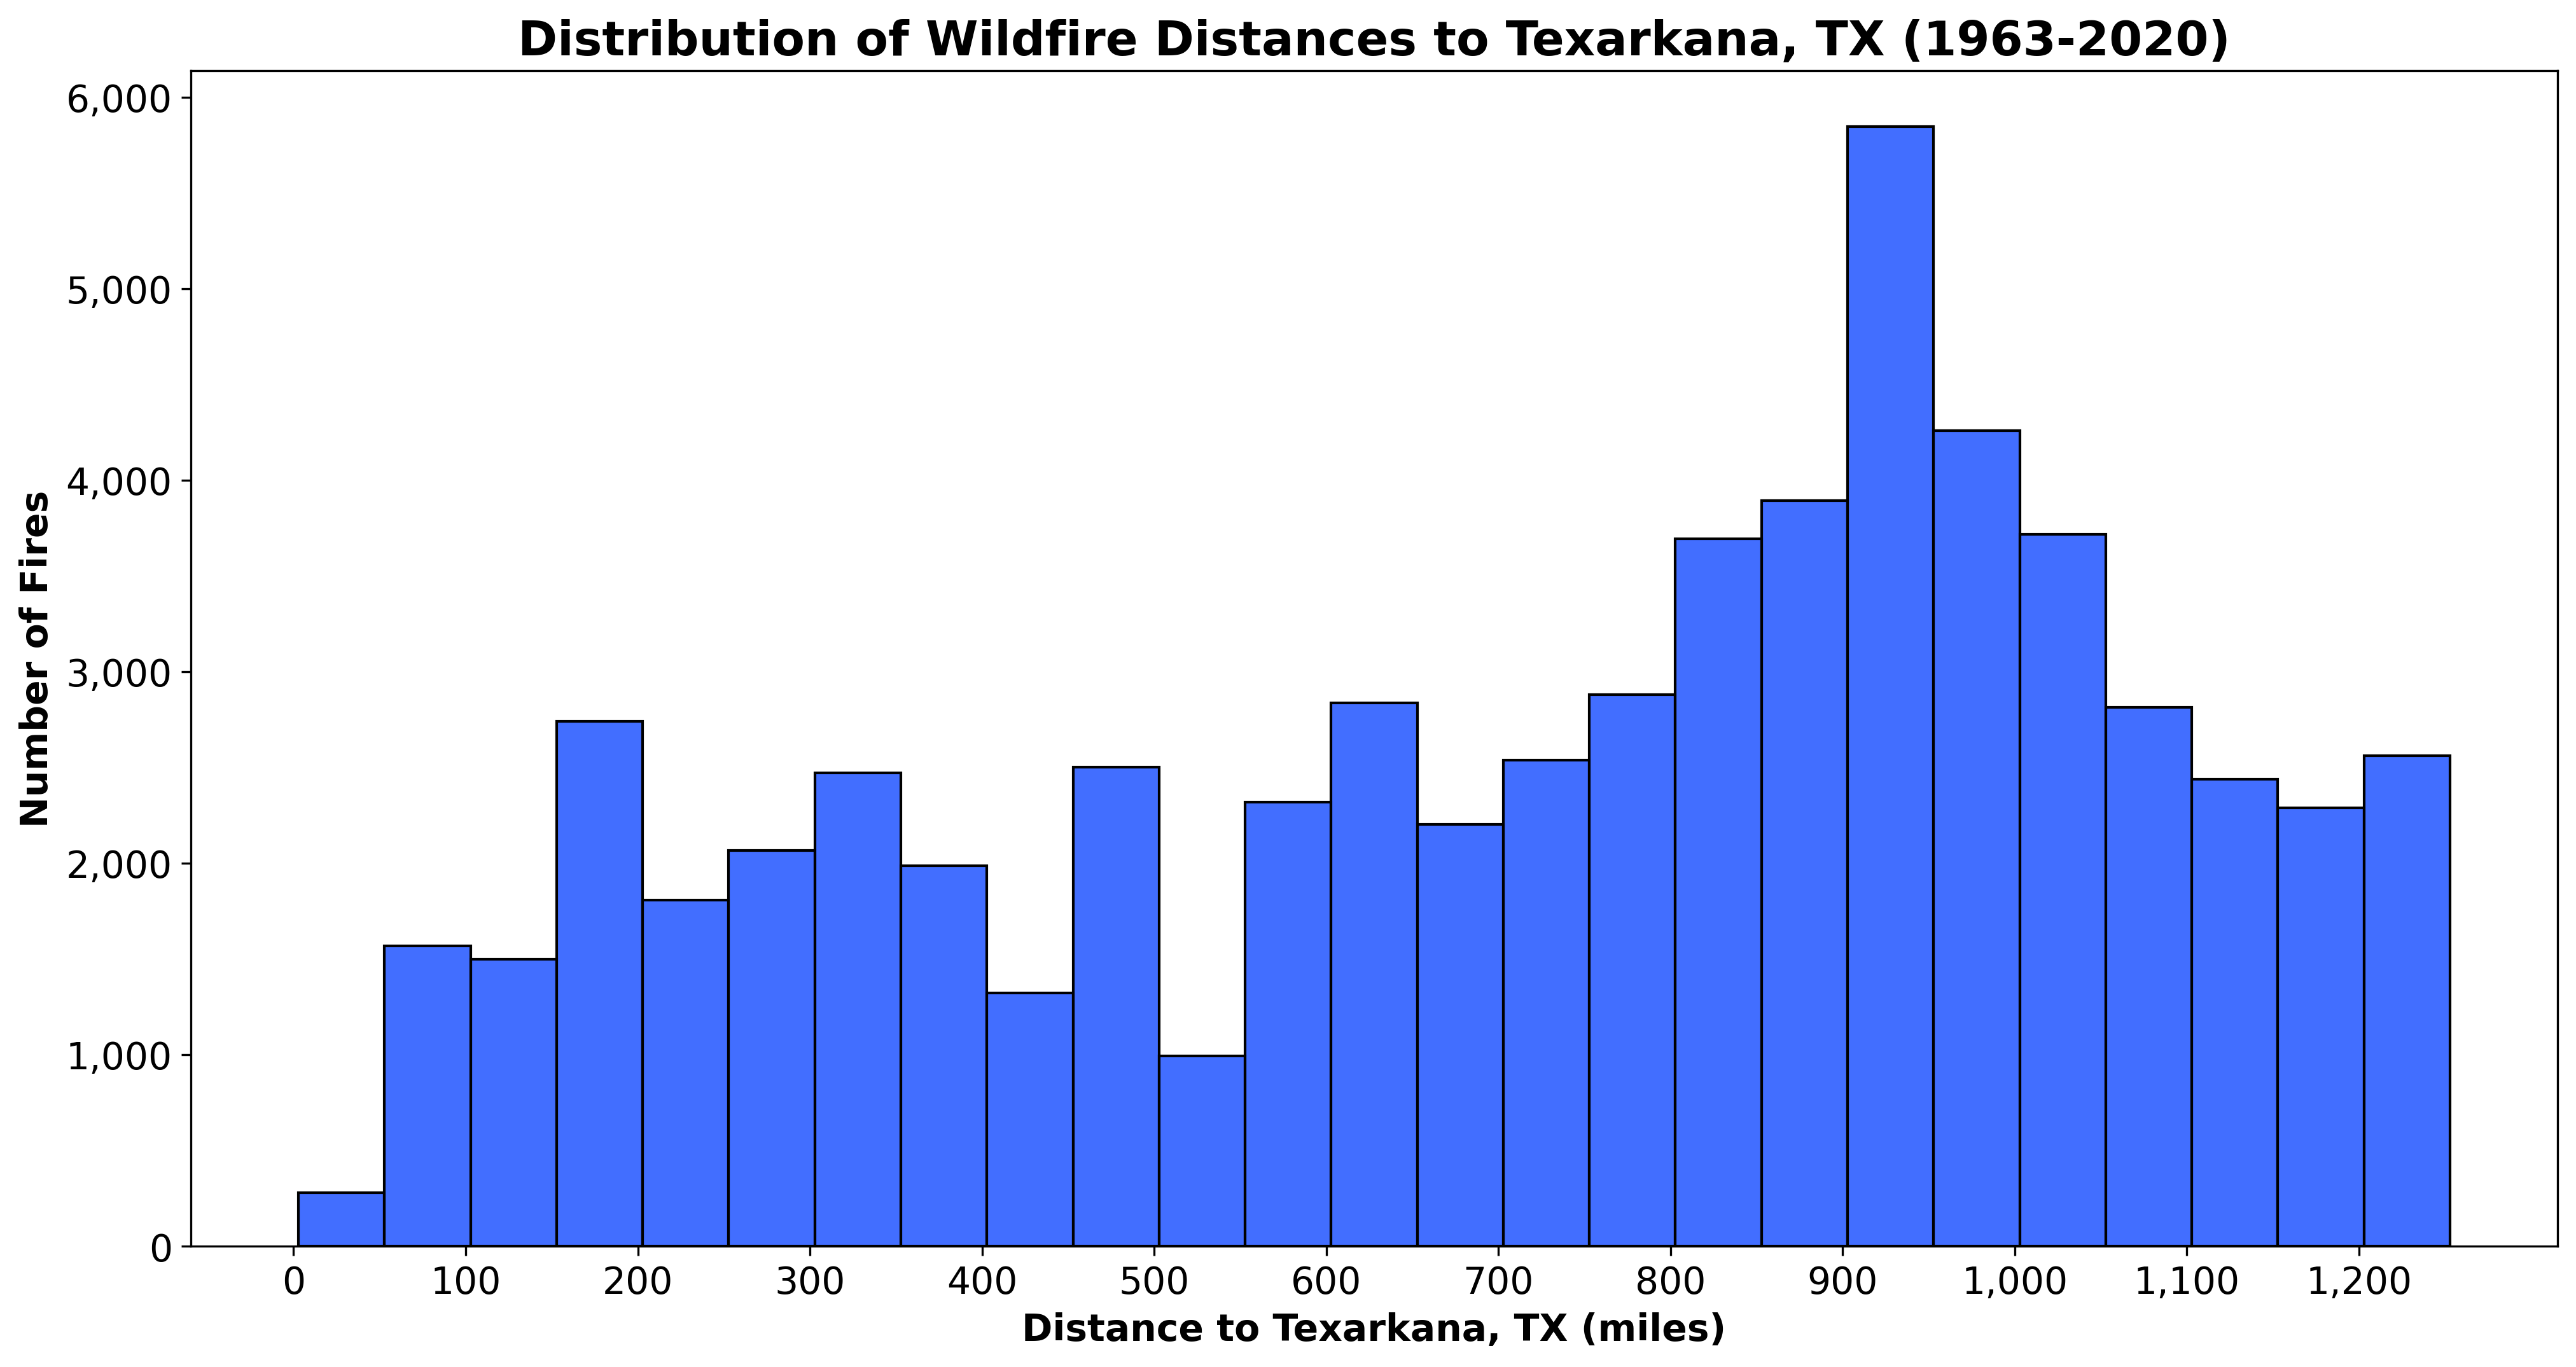

In [24]:
# Plot the distribution of wildfire distances to Texarkana, TX

# Set figure size and resolution
plt.figure(figsize=(16, 8), dpi=300)

# Create histogram
ax = sns.histplot(data=distances_df,
                  x='distance_to_txk',
                  binwidth=50,
                  color=sns.color_palette('bright')[0])

# Set labels
plt.xlabel('Distance to Texarkana, TX (miles)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Fires', fontsize=14, fontweight='bold')
plt.title('Distribution of Wildfire Distances to Texarkana, TX (1963-2020)',
          fontsize=18, fontweight='bold')

# Format axes
ax.get_xaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(range(0, 1300, 100))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save figure as .png
plt.savefig(os.path.join(WD, 'output/distance_histogram.png'))

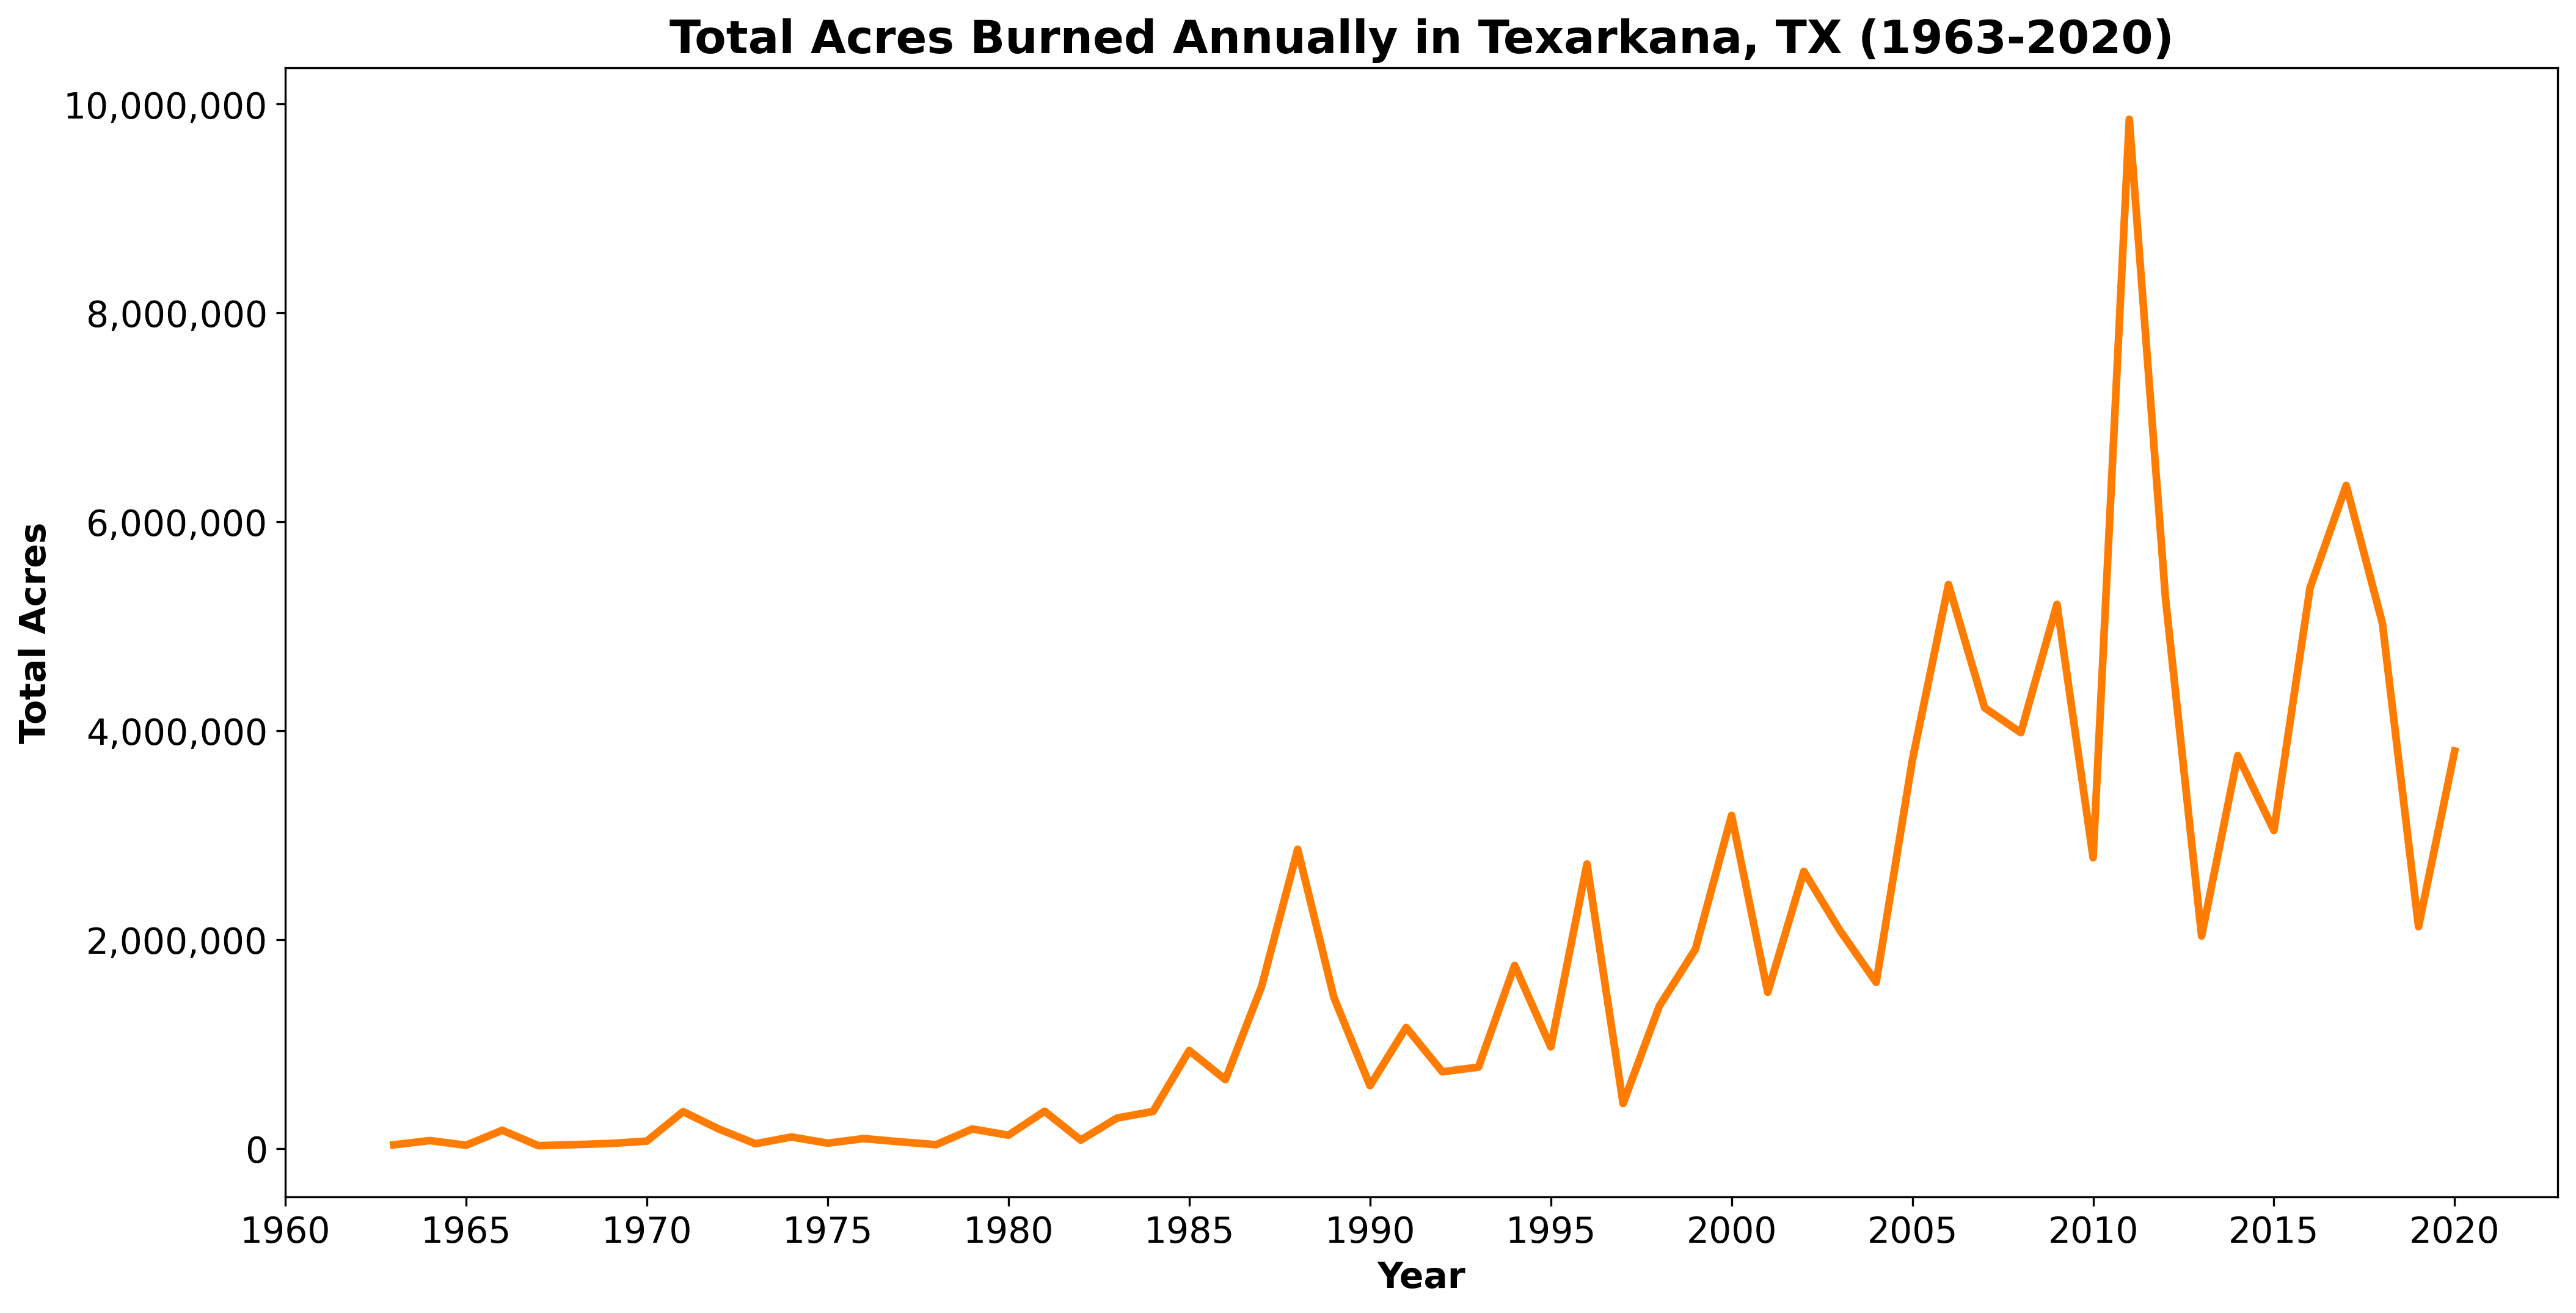

In [25]:
# Plot the annual acres burned
acres_per_year = distances_df.groupby('year')['size_acres'].sum().reset_index()

# Set figure size and resoltion
plt.figure(figsize=(16, 8), dpi=300)

# Create line plot
ax = sns.lineplot(data=acres_per_year,
                  x='year',
                  y='size_acres',
                  linewidth=3,
                  errorbar=None,
                  color=sns.color_palette('bright')[1])

# Set labels
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Acres', fontsize=14, fontweight='bold')
plt.title('Total Acres Burned Annually in Texarkana, TX (1963-2020)',
          fontsize=18, fontweight='bold')

# Format axes
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(range(1960, 2025, 5), fontsize=14)
plt.yticks(fontsize=14)

# Save figure as .png
plt.savefig(os.path.join(WD, 'output/acres_burned.png'))

In [28]:
# Show stations for each year of AQS data
station_year = aqi_df.copy()
station_year['date_local'] = pd.to_datetime(station_year['date_local'])
station_year['year'] = station_year.date_local.dt.year
station_year[['city', 'year', 'local_site_name', 'site_address', 'county', 'state']].drop_duplicates()

,city,year,local_site_name,site_address,county,state
0,Texarkana,1974,NaN,2724 NEW BOSTON RD.,Bowie,Texas
72,Texarkana,1975,NaN,2724 NEW BOSTON RD.,Bowie,Texas
199,Texarkana,1976,NaN,2724 NEW BOSTON RD.,Bowie,Texas
358,Texarkana,1977,NaN,2724 NEW BOSTON RD.,Bowie,Texas
520,Texarkana,1978,NaN,2724 NEW BOSTON RD.,Bowie,Texas
559,Texarkana,1978,NaN,12TH SPRUCE ST.,Bowie,Texas
593,Texarkana,1979,NaN,12TH SPRUCE ST.,Bowie,Texas
637,Texarkana,1980,NaN,12TH SPRUCE ST.,Bowie,Texas
689,Not in a city,1998,JONES SITE,"ROUTE 2, TEXARKANA",Bowie,Texas
1784,Not in a city,1999,JONES SITE,"ROUTE 2, TEXARKANA",Bowie,Texas


From the table above, we can see that we have one to two monitor stations per year in Texarkana, TX. To process the AQI, we will use the following steps:
1. For each day and station, take the maximum AQI across all pollutants.
    - The AQS calculates AQI for each pollutant, and reports the highest AQI out of all pollutants.
    - This is the motivation behind taking the maximum AQI for a station in any given day.
2. Then for each day, take the average AQI across all stations.
    - This ensures that if we have data from more than 1 station in the city for that day, we account for data from all stations.
3. Filter the days to include May 1 to October 31 in each year. This is the fire season.
4. Take the average of the daily AQIs within the fire season to get a measure of AQI during the fire season in each year.

In [29]:
# Convert date to Pandas datetime
aqi_df['date_local'] = pd.to_datetime(aqi_df['date_local'])

# Extract year and month from dates
aqi_df['year'] = aqi_df['date_local'].dt.year
aqi_df['month'] = aqi_df['date_local'].dt.month

# Take the maximum AQI per station per day
aqi_yearly = aqi_df.groupby(
    ['date_local', 'month',
     'year', 'site_number'])['aqi'].max().reset_index()

# Take the average AQI per day
aqi_yearly = aqi_yearly.groupby(
    ['date_local', 'month', 'year'])['aqi'].mean().reset_index()

# Filter to the fire season (May 1 to October 31)
aqi_yearly = aqi_yearly[aqi_yearly.month.between(5, 10)]

# Take the average AQI during fire season in each year
aqi_yearly = aqi_yearly.groupby('year')['aqi'].mean().reset_index()
aqi_yearly = aqi_yearly[~np.isnan(aqi_yearly.aqi)]

aqi_yearly

,year,aqi
7,1998,7.819672
8,1999,56.181818
9,2000,58.100000
10,2001,56.258621
11,2002,56.540984
12,2003,53.819672
13,2004,47.866667
14,2005,55.210526
15,2006,53.965517
16,2007,51.241935


From the table above, we notice that 1998 is likely erraneous since the AQI is very low. We will remove this year.

In [30]:
# Removing 1998 since it is likely erraneous
aqi_yearly = aqi_yearly.iloc[1:]

We will now create the annual time series of our smoke estimates. To achieve this, we will simply take the average of the smoke estimates for each year. Accumulating all of the fires in a single year makes intuitive sense. However, I have elected not to do that here. One might think that the number of fires should affect air quality. For example, years with more wildfires should have worse air quality than years with fewer wildfires on average. However, if we look at the table below, we see that this is not necessarily true. There are years with relatively high number of wildfires that have a lower AQI on average. This may be due to a myriad of reasons related to the severity of the fires or even the weather conditions. The relationship between the number of wildfires and air quality is therefore much more complex than we anticipate so I have elected not to accumulate the smoke impacts for each year.

In [31]:
# Create annual smoke estimates
smoke_yearly = distances_df.groupby('year').agg(
    {'smoke_index': 'mean', 'name': 'count'}).reset_index()

# Rename count column to n_fires
smoke_yearly.rename(columns={'name': 'n_fires'}, inplace=True)

# Merge with AQI data
smoke_chart_data = smoke_yearly.merge(aqi_yearly)
smoke_chart_data

,year,smoke_index,n_fires,aqi
0,1999,21.184046,1171,56.181818
1,2000,20.289046,1618,58.100000
2,2001,19.960345,1209,56.258621
3,2002,20.359456,1149,56.540984
4,2003,18.495357,1279,53.819672
5,2004,16.702818,1154,47.866667
6,2005,18.062161,1591,55.210526
7,2006,18.654228,2295,53.965517
8,2007,16.543901,2326,51.241935
9,2008,14.759279,2271,48.064516


In [32]:
# Get the correlation between the smoke estimates and the AQI
corr = smoke_chart_data[['smoke_index', 'aqi']].corr().smoke_index.iloc[1]
caption = f'Pearson Correlation: {corr:.0%}'

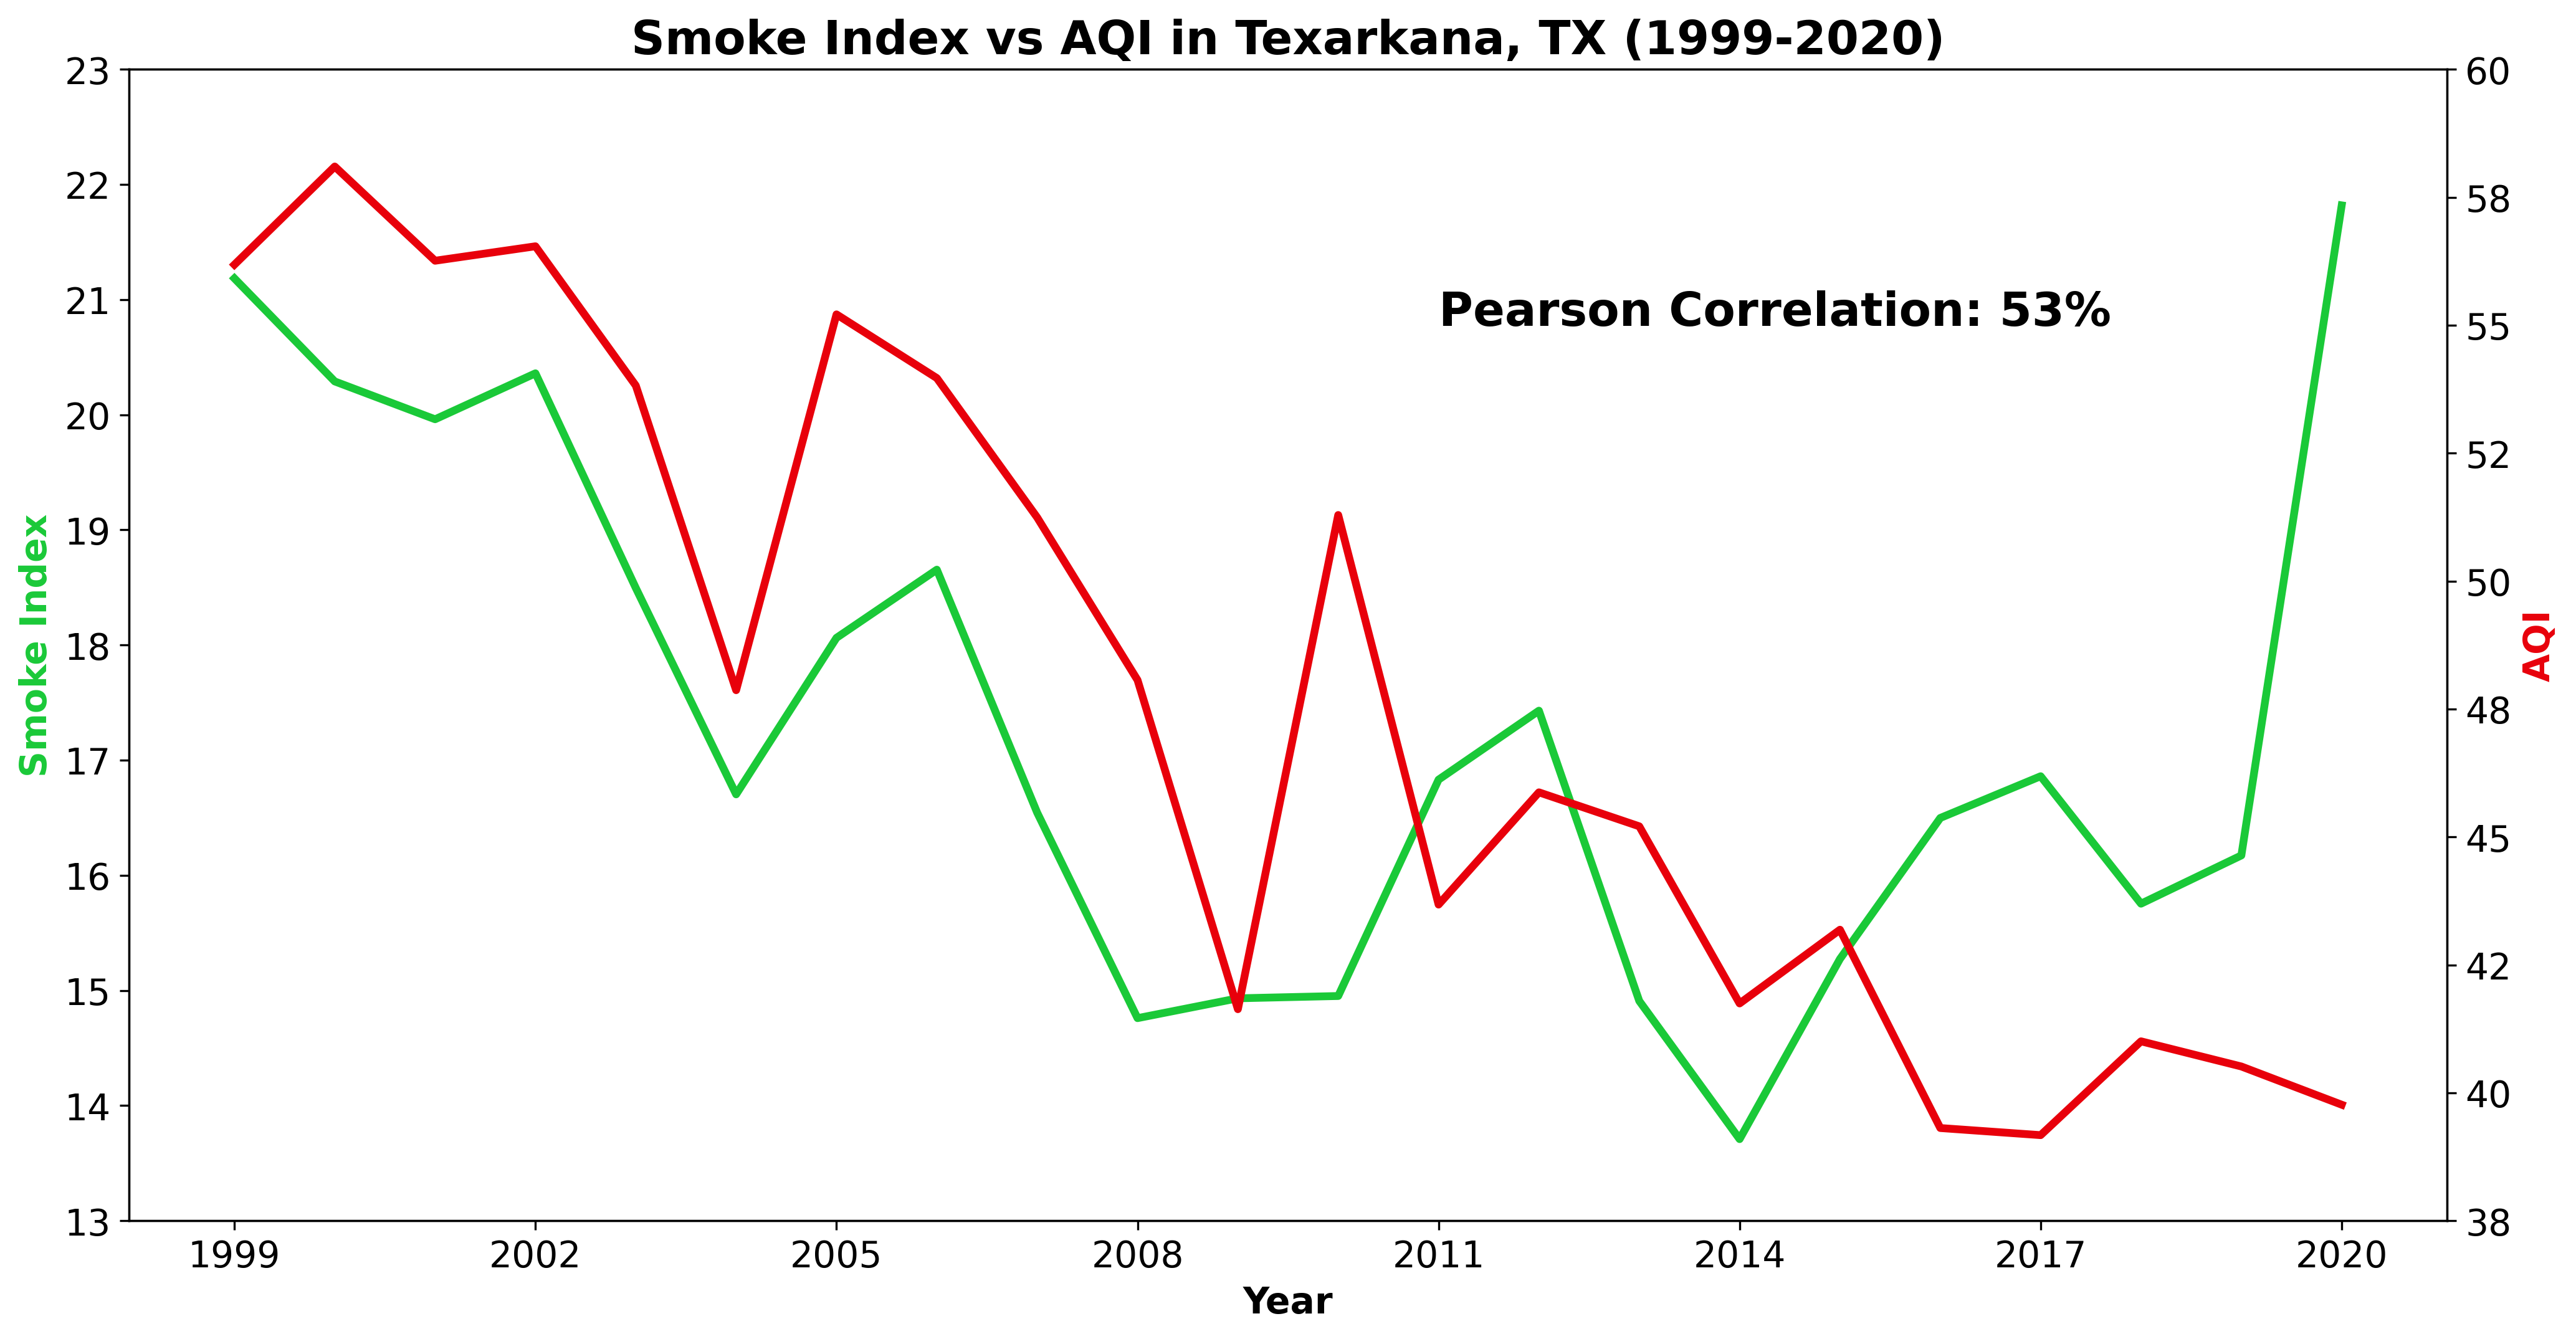

In [33]:
# Set figure size and resolution
plt.figure(figsize=(16, 8), dpi=300)

# Plot the smoke estimates and AQI
ax = sns.lineplot(data=smoke_chart_data,
                  x='year',
                  y='smoke_index',
                  linewidth=3,
                  errorbar=None,
                  color=sns.color_palette('bright')[2])

# Add a secondary axis for AQI
ax2 = ax.twinx()
sns.lineplot(data=smoke_chart_data,
             x='year',
             y='aqi',
             linewidth=3,
             errorbar=None,
             color=sns.color_palette('bright')[3],
             ax=ax2)

# Set labels
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Smoke Index', fontsize=14, fontweight='bold',
              color=sns.color_palette('bright')[2])
ax2.set_ylabel('AQI', fontsize=14, fontweight='bold',
               color=sns.color_palette('bright')[3])
plt.title('Smoke Index vs AQI in Texarkana, TX (1999-2020)',
          fontsize=18, fontweight='bold')

# Format axes
ax.set_xticks(range(1999, 2023, 3))
ax.set_xticklabels(range(1999, 2023, 3), fontsize=14)
ax.set_yticks(ax.get_yticks())
ax2.set_yticks(ax2.get_yticks())
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)
ax2.set_yticklabels(['{:.0f}'.format(x) for x in ax2.get_yticks()], fontsize=14)

# Add correlation caption
plt.text(2011, 55, caption, fontsize=18, color='black', fontweight='bold')

# Save figure as .png
plt.savefig(os.path.join(WD, 'output/est_vs_aqi.png'))

### Model smoke estimates

We will use an Autoregressive Integrated Moving Average (ARIMA) model to make predictions of smoke estimates 25 years into the future. The only predictor in this model is the time component (year). While there are more sophisticated time series forecasting models out there such as Prophet and XGBoost, those models are typically more suitable for time series models with complex relationships betweeen multiple predictors and the target variable. Since we only have one predictor, ARIMA should be sufficient to get us a baseline set of predictions.

In [34]:
# Drop the n_fires column
model_data = smoke_yearly.drop(columns='n_fires')

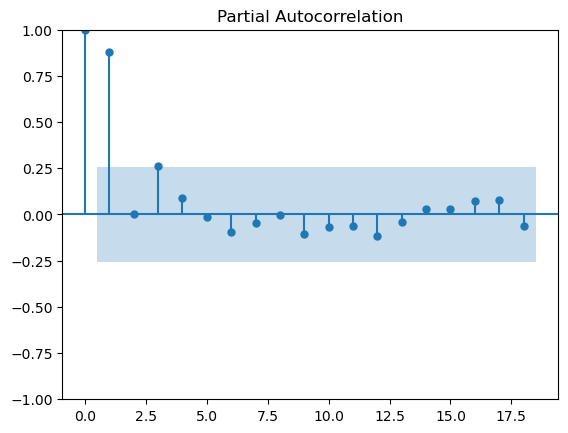

In [35]:
# Plot the partial autocorrelation
pacf = plot_pacf(model_data['smoke_index'], method='ywm')
plt.show()

The partial autocorrelation shows significant correlation between lags of 1 and 3 years since the lines for those years extend beyond the blue shade, signifying statistical significance. This suggests that using lags of 1 or 3 years may help us improve the ARIMA model.

In [36]:
# Perform Augmented Dickey-Fuller test of stationarity
adfuller(model_data['smoke_index'])

(-1.4113761307060397,
 0.5768102705899368,
 2,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 161.52385201384885)

The Augmented Dickey-Fuller test produced a p-value of 57.7%. This means that we have no evidence to reject the null hypothesis that the time series is non-stationary.

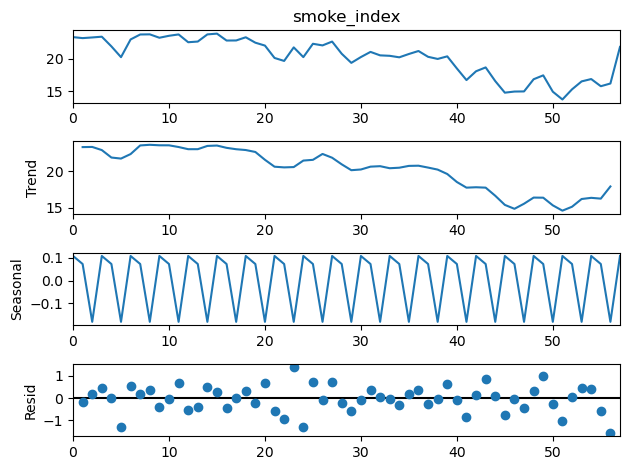

In [37]:
# Seasonal decomposition of the time series
sd = seasonal_decompose(model_data['smoke_index'], period=3)
sd.plot()
plt.show()

When we specify a periodity of 3 years, we get the seasonal decomposition above. To set up an ARIMA or SARIMA model, we need to determine the order and seasonal order of the time series. Luckily, with the pmdarima module in Python, we can automate this determination. The pmdarima module allows us to fit an ARIMA or SARIMA model and it then automatically performs parameter tuning for us.

In [85]:
# Create ARIMA model
# Specify order(p, d, q)
# p = # lags
# d = diffrencing order
# q = moving average order
arima = ARIMA(model_data['smoke_index'],
              order=(3, 0, 3)).fit()

# Forecast 29 years ahead
forecast = arima.get_forecast(steps=29)

# Obtain prediction confidence intervals
forecast_df = forecast.conf_int()

# Obtain predictions
forecast_df['smoke_index'] = forecast.predicted_mean

# Store confidence intervals and predictions in a dataframe
forecast_df['year'] = list(range(model_data.year.max() + 1,
                                 model_data.year.max() + 30))
forecast_df['type'] = 'Forecast'

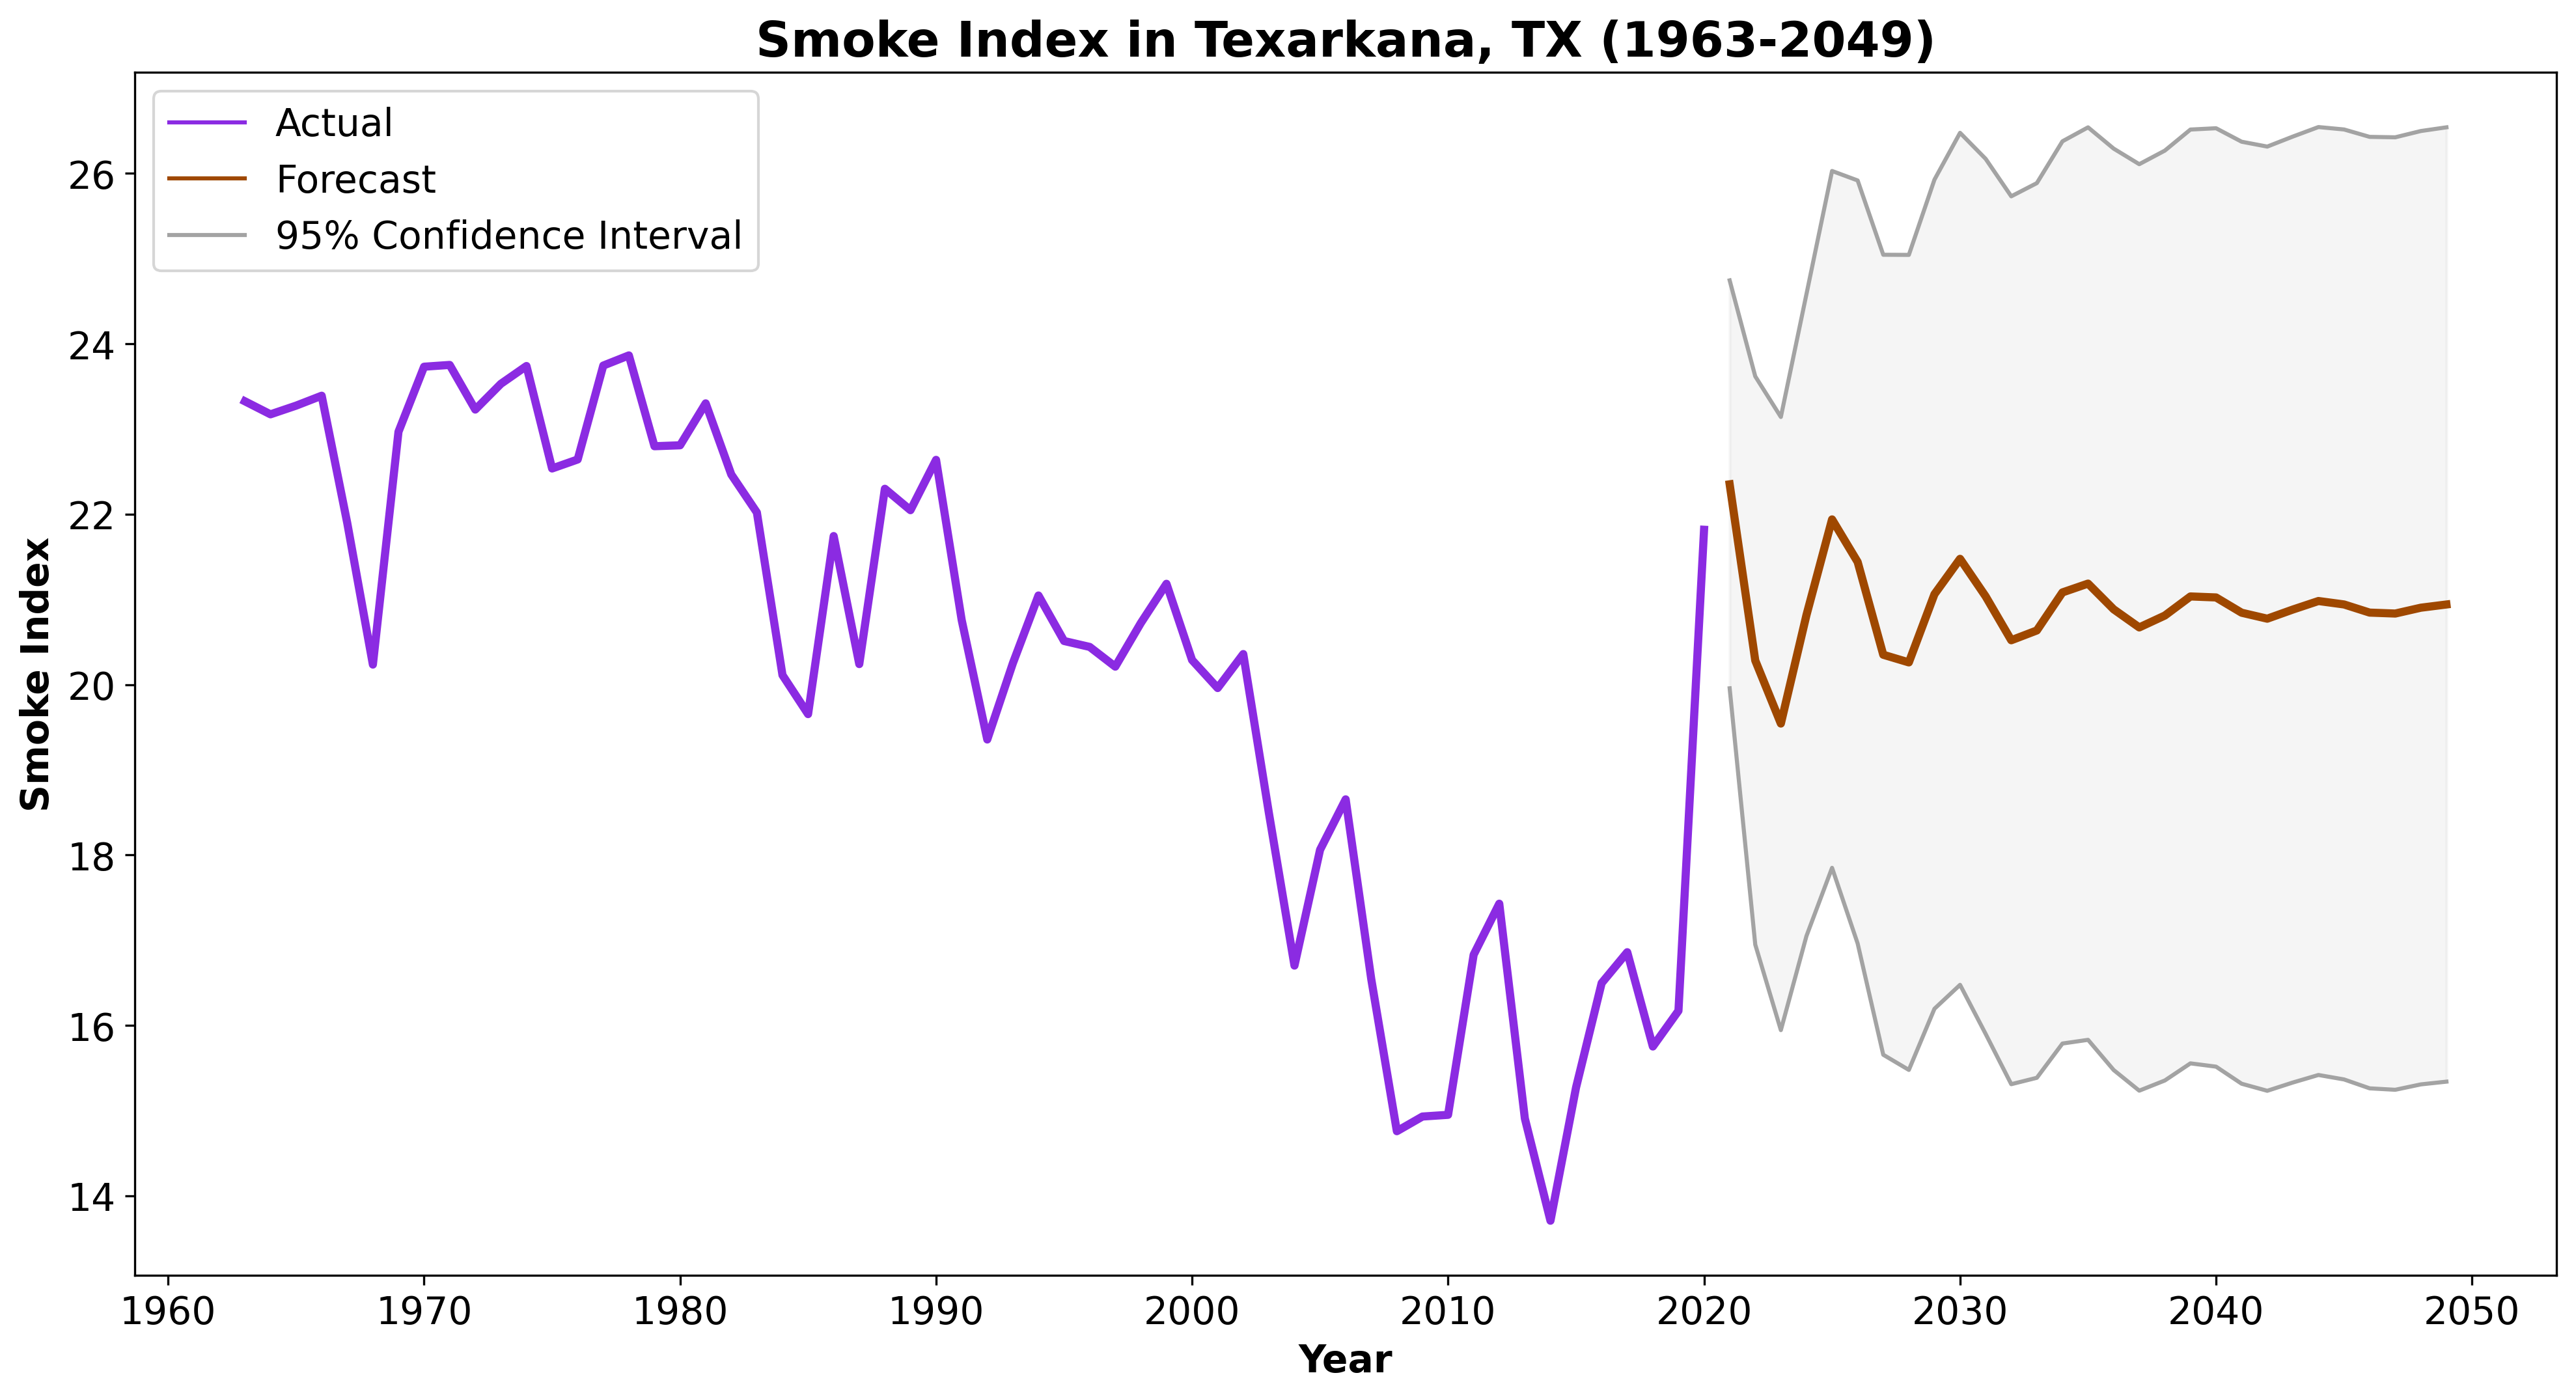

In [86]:
# Prepare data for plotting
model_data['type'] = 'Actual'

# Combine regression data and prediction data
pred_chart_data = pd.concat([model_data, forecast_df])

# Set figure size and resolution
plt.figure(figsize=(16, 8), dpi=300)

# Plot actuals and predictions
ax = sns.lineplot(data=pred_chart_data,
                  x='year',
                  y='smoke_index',
                  linewidth=3,
                  errorbar=None,
                  hue='type',
                  palette=sns.color_palette('bright')[4:6])

# Plot upper and lower bounds of confidence intervals
sns.lineplot(data=pred_chart_data,
             x='year',
             y='upper smoke_index',
             label='95% Confidence Interval',
             ax=ax,
             color=sns.color_palette('bright')[7])
sns.lineplot(data=pred_chart_data,
             x='year',
             y='lower smoke_index',
             ax=ax,
             color=sns.color_palette('bright')[7])

# Fill area between upper and lower bounds
plt.fill_between(pred_chart_data['year'],
                 pred_chart_data['upper smoke_index'],
                 pred_chart_data['lower smoke_index'],
                 color=sns.color_palette('bright')[7],
                 alpha=0.1)

# Set lables
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Smoke Index', fontsize=14, fontweight='bold')
plt.title('Smoke Index in Texarkana, TX (1963-2049)',
          fontsize=18, fontweight='bold')

# Format axes
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(range(1960, 2060, 10), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='', prop={'size': 14})

# Save figure as .png
plt.savefig(os.path.join(WD, 'output/smoke_forecast.png'))

The figure above shows the actual smoke estimates from 1963 to 2020 in purple, and the forecast smoke estimates from 2020 to 2049 in brown. The grey lines and shaded area represent the 95% confidence interval of the forecasts. We can observe that the model predictions attempt to capture the cyclical pattern of the smoke index. However, over time the forecasts start to flatline and the uncertainty becomes greater. This is likely to a combination of factors including the noise in the time series as well as the specification of the ARIMA model with regards to seasonality etc. The scarcity of time series data could also be an issue. The time series shows irregular patterns and it is likely the model does not have enough data to fully capture the patterns in the time series.